In [358]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import itertools
import skimage as sk
import cv2

from sklearn.model_selection import train_test_split
%matplotlib inline
from skimage.transform import resize


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [360]:
torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

(512, 512, 3)
(256, 256, 3)


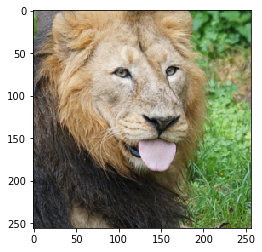

In [361]:
im = plt.imread("input/lion_orig.png")
im = sk.img_as_float(im)
print(im.shape)
im = resize(im, (im.shape[0] // 2, im.shape[1] // 2), anti_aliasing=True)
print(im.shape)
plt.imshow(im)

In [362]:
def pos_enc(p, L): 
    if L <= 0:
        return p
    v_proj = (np.pi * p)
    out_enc = np.concatenate([np.sin(v_proj), np.cos(v_proj)], axis=-1)
    for l in np.arange(1, L):
        v_proj = (pow(2.0, l) * np.pi * p)
        out_enc = np.concatenate([out_enc, np.sin(v_proj), np.cos(v_proj)], axis=-1)
    return out_enc

In [371]:
L = 0
coords = np.linspace(0, 1, im.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
X_train = torch.from_numpy(pos_enc(x_test[::2,::2], L))
y_train = torch.from_numpy(im[::2,::2])
X_train = X_train.to(device)
y_train = y_train.to(device)

print(x_test.shape)
X_train.shape, y_train.shape
# we need to apply the positional encodings for higher frequency output

(256, 256, 2)


(torch.Size([128, 128, 2]), torch.Size([128, 128, 3]))

In [372]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(max(2, 4*L), 256), # add 6 layers
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
             nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
             nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [373]:
model = MLP()
model = model.to(device)
print(model)
X_train.is_cuda, y_train.is_cuda

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=3, bias=True)
    (15): Sigmoid()
  )
)


(True, True)

In [374]:
l_r = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=l_r)
loss_fn = nn.MSELoss()
epochs = 2000

for epoch in range(epochs):
    model.train()
    X_train.to(device)
    outputs = model(X_train.float())
    loss = loss_fn(outputs, y_train)
    if epoch % 100 == 0:
        print(epoch, loss.item())
    loss.backward()
    optimizer.step()
            
    model.eval()

0 0.05564318969845772
100 0.051749005913734436
200 0.03253921866416931
300 0.04970322549343109
400 0.04932903125882149
500 0.03282766416668892
600 0.037386663258075714
700 0.02888793684542179
800 0.0272910688072443
900 0.035743240267038345
1000 0.02603451907634735
1100 0.0300641730427742
1200 0.02796248532831669
1300 0.02887222170829773
1400 0.026120668277144432
1500 0.02624463476240635
1600 0.024436205625534058
1700 0.022277669981122017
1800 0.0222854632884264
1900 0.01999329961836338


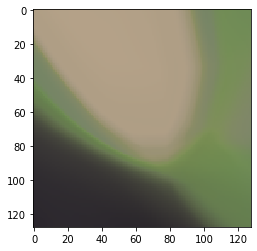

In [375]:
# WITH positional encoding (L = 5, epochs = 2000)
plt.imshow(outputs.cpu().detach().numpy())

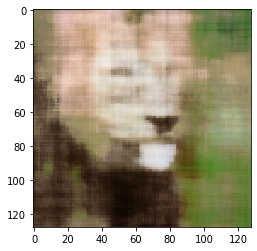

In [232]:
# WITH positional encoding (L = 8, epochs = 2000)
plt.imshow(outputs.detach().numpy())

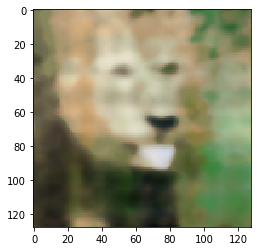

In [227]:
# WITH positional encoding (L = 5, epochs = 2000)
plt.imshow(outputs.detach().numpy())

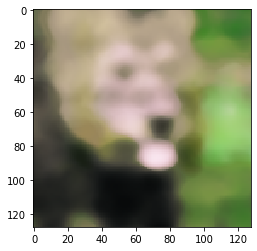

In [222]:
# WITH positional encoding (L = 4, epochs = 2000)
plt.imshow(outputs.detach().numpy())

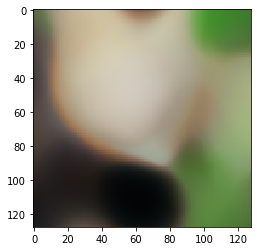

In [206]:
# WITH positional encoding (L = 2, epochs = 2000)
plt.imshow(outputs.detach().numpy())

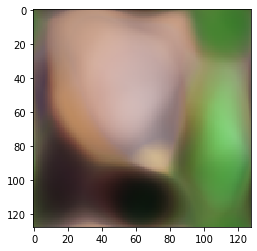

In [153]:
# WITH positional encoding (L = 1, epochs = 2000)
plt.imshow(outputs.detach().numpy())

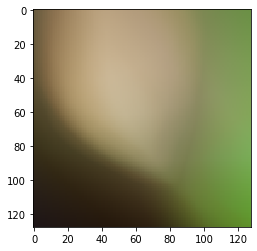

In [116]:
# WITHOUT positional encoding (epochs = 2000)
plt.imshow(outputs.detach().numpy())

## Now that we have our coordinate-based MLP built, let's try running it on some masked images and see how that impacts the outputted frequencies! ##

(512, 512, 3)


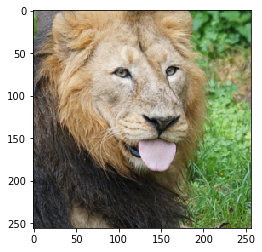

In [303]:
im = plt.imread("input/lion_orig.png")
im = sk.img_as_float(im)
print(im.shape)
im = resize(im, (im.shape[0] // 2, im.shape[1] // 2), anti_aliasing=True)
plt.imshow(im)

(128, 128, 3)


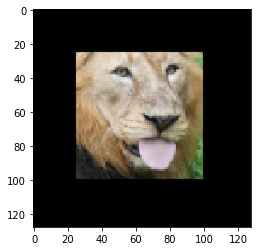

In [304]:
masked = np.zeros(im.shape, float)
x, y = 50, 50
h, w = 150, 150
masked[y:y+h,x:x+w] = im[y:y+h,x:x+w]
masked = resize(masked, (im.shape[0] // 2, im.shape[1] // 2), anti_aliasing=True)
print(masked.shape)
plt.imshow(masked)

In [301]:
L = 5
coords = np.linspace(0, 1, masked.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
X_train = torch.from_numpy(pos_enc(x_test[::,::], L))
y_train = torch.from_numpy(masked[::,::].astype(float))

print(x_test.shape)
X_train.shape, y_train.shape
# we need to apply the positional encodings for higher frequency output

(128, 128, 2)


(torch.Size([128, 128, 20]), torch.Size([128, 128, 3]))

In [302]:
l_r = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=l_r)
loss_fn = nn.MSELoss()
epochs = 2000

for epoch in range(epochs):
    model.train()
    outputs = model(X_train.float())
    loss = loss_fn(outputs, y_train)
    if epoch % 100 == 0:
        print(epoch, loss.item())
    loss.backward()
    optimizer.step()
            
    model.eval()

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'target' in call to _thnn_mse_loss_forward